# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

Dont forget to setup your LLM API key. You can also pass it to the llm object directly. 

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```


## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- **Multiple LLM Backends**: LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python
lida = Manager(text_gen = llm(provider="hf", model="TheBloke/gpt4-x-vicuna-13B-HF", device_map="auto"))
lida = Manager(text_gen = llm("openai")) 
lida = Manager(text_gen = llm("cohere")) 
```
- **Summarization Methods**: The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm. 
- **Caching**: Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.




In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [1]:
from lida import Manager, TextGenerationConfig , llm 
from lida.utils import plot_raster
import pandas as pd

## Summarize Data, Generate Goals

In [2]:
lida = Manager(text_gen = llm("openai", api_key="")) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-16k", use_cache=True)



In [9]:
# cleaned_data = lida.preprocess("../../dataset/PWC_Attrition.csv")
cleaned_data = pd.read_csv("../lida/web/files/data/PWC_Attrition.csv")
data = cleaned_data
data['liked_most'][data['liked_most'].notna()]

1       Growth/learning opportuniites
3       Growth/learning opportuniites
5       Growth/learning opportuniites
6             Others(Please Speacify)
11            Others(Please Speacify)
                    ...              
7172                       Brand Name
7173                Employee Benefits
7174            Supportive Management
7175               Career Progression
7176                   Infrastructure
Name: liked_most, Length: 5288, dtype: object

/var/folders/47/32xygt1542lgf26jnlfqkhz40000gn/T/ipykernel_82185/4266037501.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data.groupby([data['Date_of_Leaving'].dt.month, 'liked_most']).size().reset_index(name='Count')
/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(

<module 'matplotlib.pyplot' from '/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

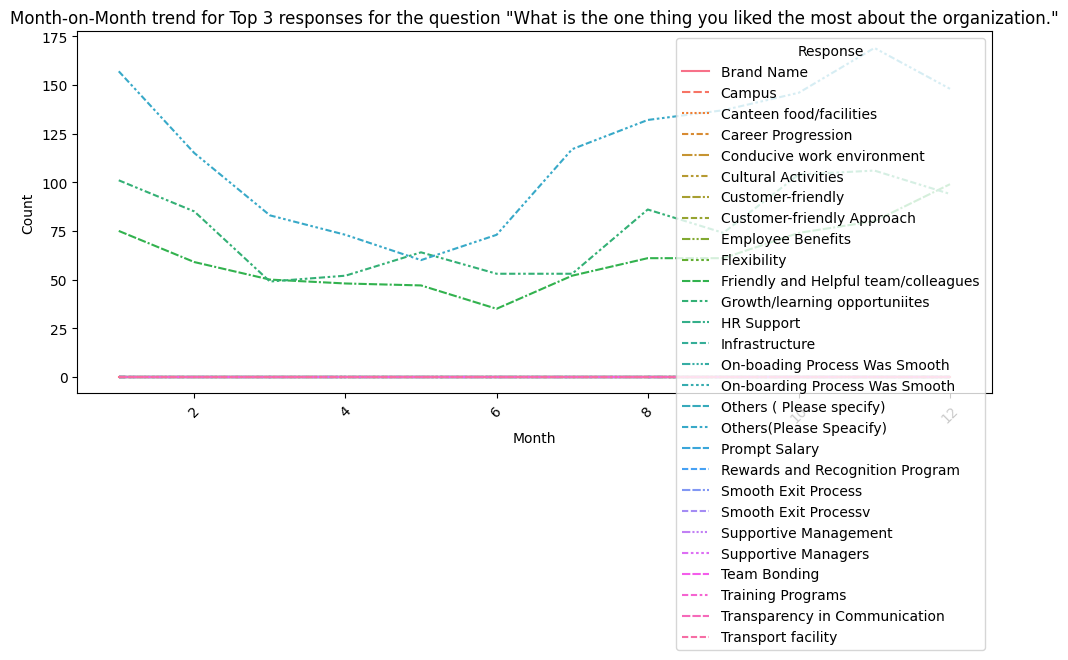

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# solution plan
# i. Convert the 'Liked_most' column to a category data type
data['liked_most'] = data['liked_most'].astype('category')

# ii. Filter the dataset to include only the top 3 responses for the question 'What is the one thing you liked the most about the organization'
top_3_responses = data['liked_most'].value_counts().nlargest(3).index
filtered_data = data[data['liked_most'].isin(top_3_responses)]

# iii. Convert the 'Date_of_Leaving' column to a datetime data type
data['Date_of_Leaving'] = pd.to_datetime(data['Date_of_Leaving'], format='%d/%m/%Y')

# iv. Group the data by month and count the number of occurrences for each response
grouped_data = filtered_data.groupby([data['Date_of_Leaving'].dt.month, 'liked_most']).size().reset_index(name='Count')

# v. Pivot the data to have the responses as columns and the months as rows
pivot_data = grouped_data.pivot(index='Date_of_Leaving', columns='liked_most', values='Count')

# vi. Plot the Month-on-Month trend for the top 3 responses
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_data)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Month-on-Month trend for Top 3 responses for the question "What is the one thing you liked the most about the organization."')
plt.legend(title='Response')
plt.xticks(rotation=45)
plt.tight_layout()

# vii. Return the plot
plt

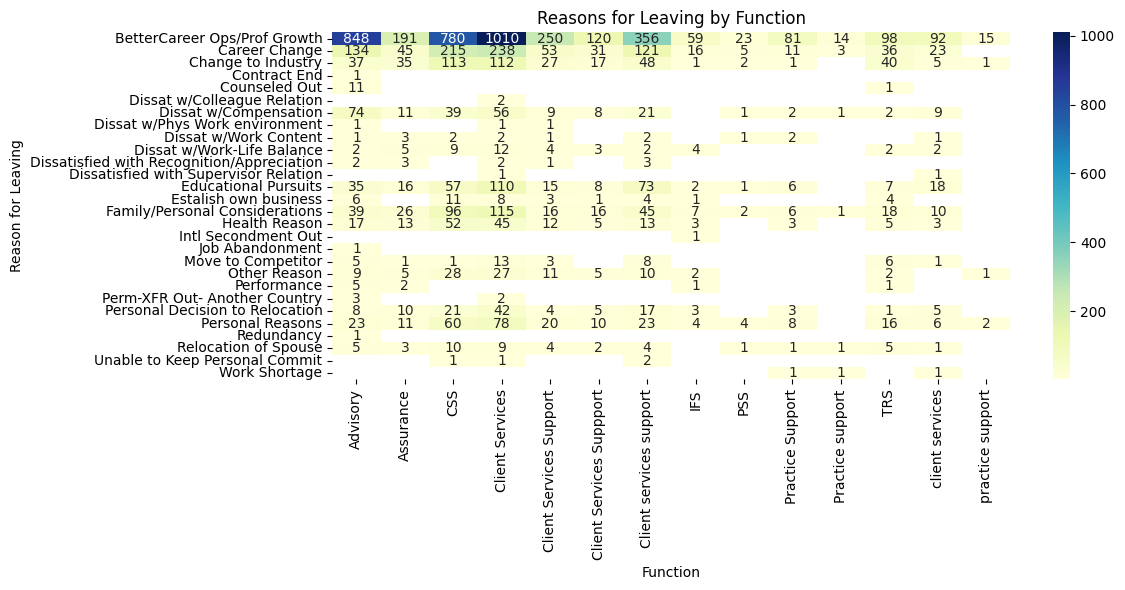

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    # Filter the dataset to include only the necessary columns
    filtered_data = data[['function', 'reason_for_leaving']]

    # Group the data by 'function' and 'reason_for_leaving' and count the number of occurrences
    grouped_data = filtered_data.groupby(['function', 'reason_for_leaving']).size().reset_index(name='count')

    # Pivot the data to have 'function' as columns, 'reason_for_leaving' as index, and the count as values
    pivot_table = grouped_data.pivot(index='reason_for_leaving', columns='function', values='count')

    # Plot the pivot table using a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.xlabel('Function')
    plt.ylabel('Reason for Leaving')
    plt.title('Reasons for Leaving by Function')
    plt.tight_layout()

    return plt
    
data = cleaned_data
chart = plot(data)

/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


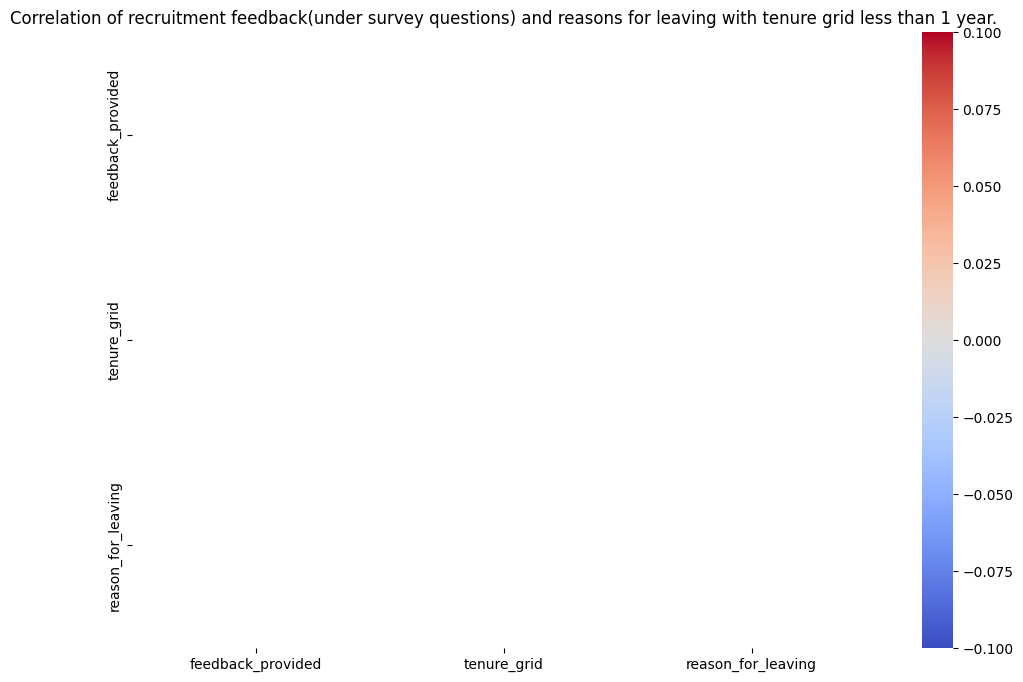

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
data = cleaned_data
# solution plan
# i. Convert date fields to date types
data['client_attrition_month'] = pd.to_datetime(data['client_attrition_month'], errors='coerce')
data['date_of_join'] = pd.to_datetime(data['date_of_join'], errors='coerce')
data['date_of_leaving'] = pd.to_datetime(data['date_of_leaving'], errors='coerce')
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')
data['hire_date'] = pd.to_datetime(data['hire_date'], errors='coerce')
data['resignation_date'] = pd.to_datetime(data['resignation_date'], errors='coerce')
data['last_promotion_date'] = pd.to_datetime(data['last_promotion_date'], errors='coerce')

# ii. Filter data for tenure grid less than 1 year
filtered_data = data[data['tenure_grid'] == 'Less than 12 months']

# iii. Select relevant columns for correlation
correlation_data = filtered_data[['feedback_provided', 'tenure_grid', 'reason_for_leaving']]

def plot(data: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation of recruitment feedback(under survey questions) and reasons for leaving with tenure grid less than 1 year.', wrap=True)
    return plt

chart = plot(correlation_data)

/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


TypeError: 'module' object is not callable

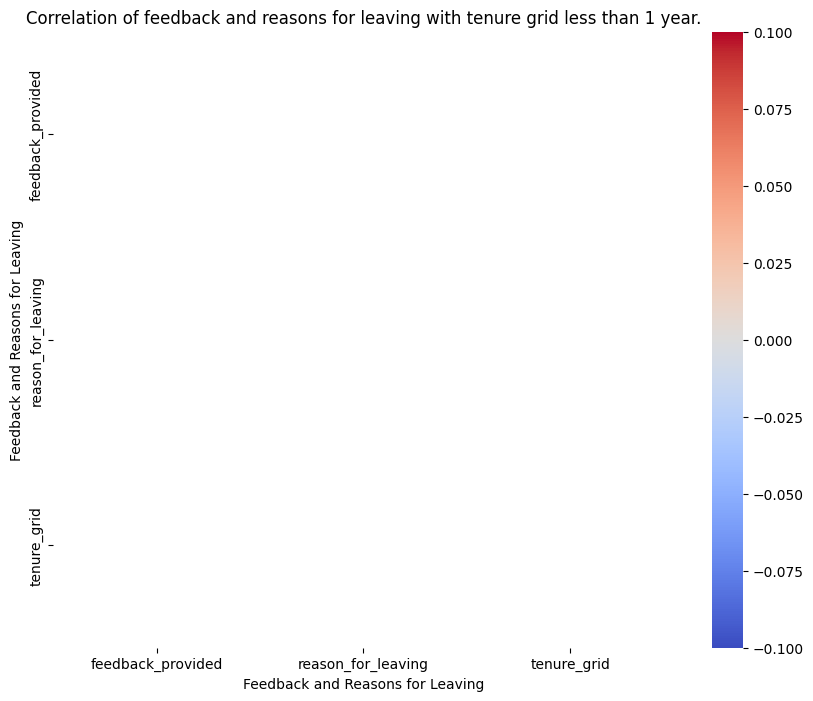

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = cleaned_data
# solution plan
# i. Convert date fields to date types
data['client_attrition_month'] = pd.to_datetime(data['client_attrition_month'], errors='coerce')
data['date_of_join'] = pd.to_datetime(data['date_of_join'], errors='coerce')
data['date_of_leaving'] = pd.to_datetime(data['date_of_leaving'], errors='coerce')
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')
data['hire_date'] = pd.to_datetime(data['hire_date'], errors='coerce')
data['resignation_date'] = pd.to_datetime(data['resignation_date'], errors='coerce')
data['last_promotion_date'] = pd.to_datetime(data['last_promotion_date'], errors='coerce')

# ii. Filter data for tenure grid less than 1 year
filtered_data = data[data['tenure_grid'] == 'Less than 1 year']

# iii. Select relevant columns for correlation analysis
correlation_data = filtered_data[['feedback_provided', 'reason_for_leaving', 'tenure_grid']]

# iv. Create a correlation matrix
correlation_matrix = correlation_data.corr()

# v. Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# vi. Set chart title and labels
plt.title('Correlation of feedback and reasons for leaving with tenure grid less than 1 year.')
plt.xlabel('Feedback and Reasons for Leaving')
plt.ylabel('Feedback and Reasons for Leaving')

# vii. Return the plot
chart = plt(data)

In [10]:
cleaned_data_cols = cleaned_data.columns.tolist()
json.dump(cleaned_data_cols, open('../cleaned_col_names.json','w'))

In [2]:
import json

In [4]:
cols = json.load(open('../cleaned_col_names.json','r'))
values = []
for key, value in cols.items():
    if value not in values:
        values.append(value)
    else:
        print(value)

tenure_in_same_role
last_name
comment
comment
comment
comment
comment
comment
comment
comment
comment
comment
comment
comment


In [ ]:
summary = lida.summarize("../../dataset/PWC_Attrition.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=1, textgen_config=textgen_config)
print(goals)

## Generate Visualizations

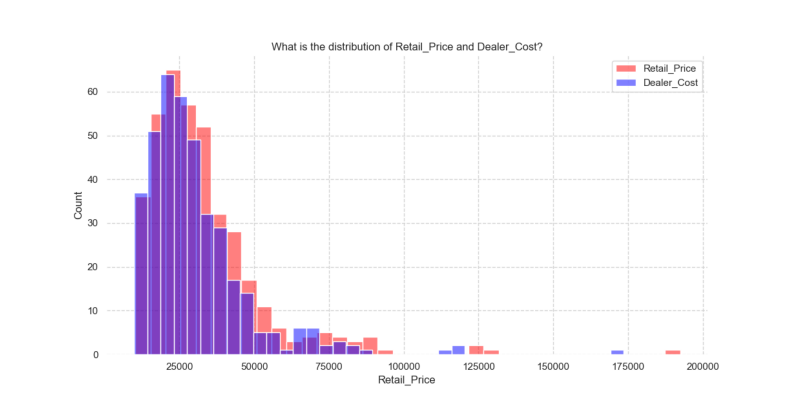

In [4]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
# plot raster image of chart
plot_raster(charts[0].raster) 

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

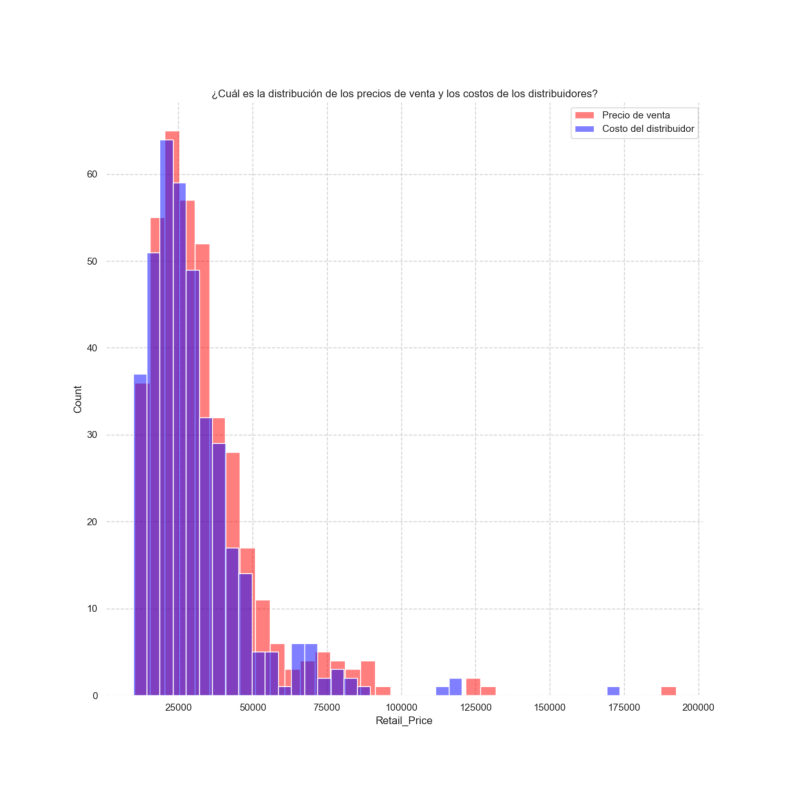

In [5]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["zoom in 50%", "make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [6]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart is a histogram plot created using the seaborn library. The chart shows the distribution of two variables, Retail_Price and Dealer_Cost, using different colors to differentiate between them. The goal of the chart is to compare the distribution of the two variables and identify any patterns or differences between them. The chart is easy to read and understand, with clear labels and a legend to explain the colors used.
transformation  **  There is no data transformation in this code. The plot function takes a pandas DataFrame as input and uses it to create the histogram plot.
visualization  **  The code first sets the style of the plot to 'whitegrid' using the seaborn set function. It then creates a figure and axis object using the subplots function from matplotlib, with a size of 12 by 6 inches. Two histograms are then created using the histplot function from seaborn, one for the Retail_Price variable and one for the Dealer_Cost variable. The Retail_Price his

## Visualization code self-evaluation and repair

In [7]:
evaluations = lida.evaluate(code=code,  goal=goals[i], library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 There are no bugs, syntax errors, or typos in the code. The code should compile without any issues.
	**********************************
transformation Score 10 / 10
	 The data is not transformed in any way, but it is appropriately filtered by the x-axis variables Retail_Price and Dealer_Cost.
	**********************************
compliance Score 10 / 10
	 The code meets the specified visualization goals of showing the distribution of Retail_Price and Dealer_Cost.
	**********************************
type Score 10 / 10
	 The histogram is an appropriate visualization type for showing the distribution of continuous variables like Retail_Price and Dealer_Cost.
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately with the x-axis variables Retail_Price and Dealer_Cost.
	**********************************
aesthetics Score 10 / 10
	 The aesthetics of the visualization are appropriate for a histogram, with different colors for each va

## Visualization Recommendation

In [8]:
import json 

dstring = """['import seaborn as sns\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndef plot(data: pd.DataFrame):\n    # solution code\n    plt.figure(figsize=(10, 6))\n    sns.scatterplot(data=data, x="Retail_Price", y="Horsepower_HP_", hue="Type", style="AWD")\n    plt.title("What is the relationship between Retail_Price, Horsepower_HP_ and Type?", wrap=True)\n    plt.xlabel("Retail Price")\n    plt.ylabel("Horsepower_HP_")\n    plt.tight_layout()\n    return plt\n\nchart = plot(data)']"""
# d0 = json.loads(dstring)

In [9]:
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=data, x="Type", y="Retail_Price", hue="AWD")
    plt.title('What is the distribution of Retail_Price by Type and AWD?', wrap=True)
    plt.legend()
    return plt;
    
chart = plot(data)
****
 name 'sns' is not defined
seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=data, x="Type", y="Retail_Price", hue="AWD")
    plt.title('What is the distribution of Retail_Price by Type and AWD?', wrap=True)
    plt.legend()
    return plt;
    
chart = plot(data)
****
 name 'sns' is not defined


In [10]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    # print(chart.code, "\n====================\n")  
    # plot raster image of chart
    plot_raster(chart.raster) 
    pass

Recommended 0 charts


## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [11]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [12]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, rain drops, highly detailed, no blur, white background")

/home/victordibia/miniconda3/envs/coral/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 27 files: 100%|██████████| 27/27 [00:00<00:00, 179755.89it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.64it/s]


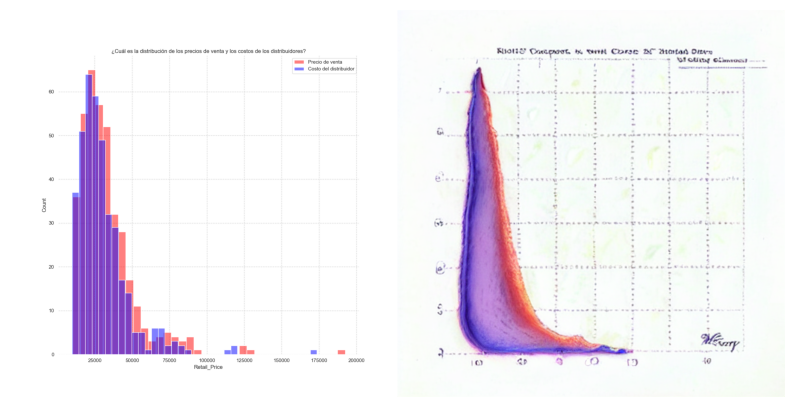

In [13]:
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 

In [34]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('../../dataset/PWC_Attrition.csv')
df.drop(index=0, inplace=True)

/var/folders/47/32xygt1542lgf26jnlfqkhz40000gn/T/ipykernel_10583/1135881995.py:3: DtypeWarning: Columns (0,2,4,9,12,14,17,18,19,24,26,27,29,35,36,37,39,41,46,47,48,50,55,59,60,62,69,70,74,75,76,77,92,93,94,95,96,97,98,99,100,101,103,105,107,109,111,114,116,120,122,124,126,128,132,133,139,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,207,208,209,210,211,212) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../dataset/PWC_Attrition.csv')


In [42]:
cols = df.columns
len(df[cols[1]])
df[cols[15]].dtype

dtype('O')

In [3]:
df_final = df.drop(index=0)
df_final = df_final.fillna("")

In [13]:
changed_names_str = "id,client_name,campaign_id,campaign_name,employee_id,first_name,client_attrition_month,join_date,leave_date,tenure_in_months,tenure_grid,birth_date,age,contact_numbers,job_level,region_zone,last_name,Current_designation,_Tenure_in_same_role_In_Years_,department,primary_language,hire_date,secondary_language,manager_gender,tenure_at_term_date,language_2,resignation_date,candidate_workday_id,function,cost_center_id,termination_type,unnamed_31,sbu,email_id,leaving_reason,candidate_name,manager_email,center,los,same_role_tenure_years,recruitment_channel_6m,vertical,job_band,mobile_number,counselor_type,competency,is_manager_first_time,coach_id,division,job_band_1,counselor,sub_sbu,manager_name,shift_type,role_type,manager_tenure,promoted_internally,reason_for_leaving,location,emergency_contact,dept_type,last_promotion_date,manager_mobile,gender,call_type,current_perf_rating,manager_name,region,employee_last_name,cost_center_id_1,bu,designation,alternate_mobile,email,date_of_joining,sub_vertical,middle_name,sub_reason_leaving,red_flag,notes,interview_status,non_contactable_status,non_contactable_notes,assigned_to,start_time,end_time,decision_trigger,recruitment_positives,recruitment_improvements,supervisor_name,enps_comments,retention_opportunities,work_location_status,work_location_comments,safety_measures_satisfaction,safety_measures_comments,org_improvements,wfh_challenges,wfh_challenges_comments,challenges_solutions,future_wfh_challenges,role_clarity_score,role_clarity_comments,onboarding_score,onboarding_comments,manager_competence_score,manager_competence_comments,team_ownership_score,team_ownership_comments,query_resolution_score,query_resolution_comments,manager_unbiased_score,manager_unbiased_comments,new_role_designation,senior_leadership_score,senior_leadership_comments,feedback_score,feedback_comments,rework_with_manager,rework_with_manager_comments,role_satisfaction_score,role_satisfaction_comments,rewards_recognition_score,rewards_recognition_comments,team_dynamics_score,team_dynamics_comments,performance_management_system_score,performance_management_system_comments,recommendation_score,recommendation_comments,liked_most,liked_most_comments,change_request,change_request_comments,rejoin_willingness,rejoin_comments,same_industry,same_industry_comments,hike_received,communication_clarity_score,communication_clarity_comments,hike_received,hike_received_comments,resignation_contact,resignation_contact_comments,retention_effort,retention_effort_comments,current_workplace,_According_to_you_is_the_verbatim_a_good_one_that_should_be_highlighted_to_the_client_93_,_According_to_you_is_the_verbatim_a_good_one_that_should_be_highlighted_to_the_client_comments_93_,hr_policies_friendly,hr_policies_friendly_comments,hr_policies_feedback,hr_interaction_frequency,hr_interaction_comments,hr_approachability,hr_approachability_comments,negative_hr_comments,negative_keywords,additional_comments,rarely_never_comments,Comment_negative_keywords_1880_.1,positive_keywords,work_distribution_comments,work_distribution_additional_comments,Comment_For_instances_when_the_response_is_Rarely_or_Never_1872_.1,Comment_negative_keywords_1880_.2,Comment_positive_keywords_1879_.1,empathy_and_care_comments,additional_empathy_and_care_comments,Comment_For_instances_when_the_response_is_Rarely_or_Never_1872_.2,Comment_negative_keywords_1880_.3,Comment_positive_keywords_1879_.2,meritocracy_belief,meritocracy_comments,fairness_observation,fairness_comments,Comment_positive_keywords_1879_.3,candidate_support_instances,pressure_handling_opinion,pressure_handling_comments,Comment_For_instances_when_the_response_is_Rarely_or_Never_1872_.3,PwC_values_instances,ethics_encouragement,ethics_encouragement_comments,Comment_Negative_Keywords_1880_,Comment_Positive_Keywords_1879_,candidate_approachability,candidate_approachability_comments,two_way_interactions,two_way_interactions_comments,interaction_opportunity,interaction_opportunity_comments,supervisor_designation,received_constructive_feedback,constructive_feedback_comments,annual_goal_setting,annual_goal_setting_comments,goal_clarity,goal_clarity_comments,improvement_suggestions,improvement_suggestions_comments,new_employer_category,new_employer_category_comments,primary_reason_for_leaving,secondary_reason_for_leaving,tertiary_reason_for_leaving,primary_secondary_reason_for_leaving,secondary_secondary_reason_for_leaving,tertiary_secondary_reason_for_leaving,primary_tertiary_reason_for_leaving,secondary_tertiary_reason_for_leaving,tertiary_tertiary_reason_for_leaving,controllable_factors,question_mappings"
changed_names_list = changed_names_str.split(',')
print(len(changed_names_list))

215


In [5]:
df_final[:2]

,id,Client_Name,Campaign_ID,Campaign_Name,Employee_ID,First_Name,Client_Attrition_Month,Date_of_Join,Date_of_Leaving,Tenure_In_Months,Tenure_Grid,Date_of_Birth,Age,All_Phone_Numbers_(Home_and_Work),Job_Level,Region_/_Zone,Last_Name,Current_designation,"""Tenure_in_same_role_(In_Years)""",Department_/_Business_Unit_/_Vertical,Language,Hire_date,Langauge_2,Manager_/_Supervisor's_gender,PwC_Tenure_(as_of_Term_Date),Lang_2,Date_of_Resignation,Candidate_Workday_ID,Function,Cost_Center_ID,Voluntary/Involuntary,Unnamed: 31,SBU,Email_ID,Reason_for_leaving_stated_to_employer,Candidate_name,Manager_Email,Center,LoS,Tenure_in_same_role_(In_Years),Recruitment_Channel(for_0_to_6_months_only),Vertical,Job_Band,Mobile_Number,Counsellor_Type,Competency,Is_the_Manager_/_Supervisor_a_first_time_manager?,Coach_ID,Division,Job_Band.1,Counselor,Sub-SBU,Name_of_Employee's_Manager_/_Supervisor,Type_of_shift_the_team_works_in_(Day/_Night),Type_of_role_(Supervisory/_Individual_contributor_etc.),Manager_/_Supervisor's_tenure_in_the_organisation,Promoted_internally_(Yes_or_No),Reason_for_Leaving,Location,Emergency_contact_number,Type_of_Department_(Technical/Administrative/R&D/Client_Facing_etc.),If_Yes_-_Date_of_Last_promotion,Manager_Mobile,Gender,Call_Type,Employee's_Current_performance_rating,Manager_Name,Region,Last_Name_of_the_employee,Cost_Center_ID.1,BU,Designation,Alternate_Mobile,Email,Date_of_Joining,Sub_Vertical,Middle_Name,Sub_Reason_for_Leaving,Red_Flag,Notes,Interview_Status,Non_contactable_status,Non_contactable_notes,Assigned_To,Start_time,End_Time,answer.1.Text_box,answer.15.Text_box,answer.16.Text_box,answer.17.Text_box,answer.33.Text_box,answer.97.Text_box,answer.45.Multiple_choice,comment.45.Multiple_choice,answer.46.Multiple_choice,comment.46.Multiple_choice,answer.47.Text_box,answer.48.Multiple_choice,comment.48.Multiple_choice,answer.49.Text_box,answer.50.Text_box,answer.98.Star_Rating,comment.98.Star_Rating,answer.99.Star_Rating,comment.99.Star_Rating,answer.103.Star_Rating,comment.103.Star_Rating,answer.2439.Star_Rating,comment.2439.Star_Rating,answer.2440.Star_Rating,comment.2440.Star_Rating,answer.105.Star_Rating,comment.105.Star_Rating,answer.504.Text_box,answer.109.Star_Rating,comment.109.Star_Rating,answer.107.Star_Rating,comment.107.Star_Rating,answer.108.Multiple_choice,comment.108.Multiple_choice,answer.110.Star_Rating,comment.110.Star_Rating,answer.111.Star_Rating,comment.111.Star_Rating,answer.113.Star_Rating,comment.113.Star_Rating,answer.2535.Star_Rating,comment.2535.Star_Rating,answer.71.Star_Rating,comment.71.Star_Rating,answer.2432.Multiple_choice,comment.2432.Multiple_choice,answer.2458.Multiple_choice,comment.2458.Multiple_choice,answer.117.Multiple_choice,comment.117.Multiple_choice,answer.119.Multiple_choice,comment.119.Multiple_choice,answer.120.Text_box,answer.2441.Star_Rating,comment.2441.Star_Rating,answer.121.Multiple_choice,comment.121.Multiple_choice,answer.95.Checkbox,comment.95.Checkbox,answer.96.Multiple_choice,comment.96.Multiple_choice,answer.118.Text_box,answer.93.Multiple_choice,comment.93.Multiple_choice,answer.1096.Multiple_choice,comment.1096.Multiple_choice,answer.1097.Text_box,answer.1098.Multiple_choice,comment.1098.Multiple_choice,answer.573.Multiple_choice,comment.573.Multiple_choice,answer.1099.Text_box,answer.1880.Text_box,answer.1902.Text_box,answer.1872.Text_box,answer.1880.Text_box.1,answer.1879.Text_box,answer.1898.Multiple_choice,comment.1898.Multiple_choice,answer.1872.Text_box.1,answer.1880.Text_box.2,answer.1879.Text_box.1,answer.1894.Multiple_choice,comment.1894.Multiple_choice,answer.1872.Text_box.2,answer.1880.Text_box.3,answer.1879.Text_box.2,answer.1890.Multiple_choice,comment.1890.Multiple_choice,answer.1886.Multiple_choice,comment.1886.Multiple_choice,answer.1879.Text_box.3,answer.1883.Text_box,answer.1882.Multiple_choice,comment.1882.Multiple_choice,answer.1872.Text_box.3,answer.1878.Text_box,answer.1877.Multiple_choice,comment.1877.Multiple_choice,answer.1880.Text_box.

In [14]:
# Get the names of all columns
column_names = df.columns.tolist()
column_names

['id',
 'Client_Name',
 'Campaign_ID',
 'Campaign_Name',
 'Employee_ID',
 'First_Name',
 'Client_Attrition_Month',
 'Date_of_Join',
 'Date_of_Leaving',
 'Tenure_In_Months',
 'Tenure_Grid',
 'Date_of_Birth',
 'Age',
 'All_Phone_Numbers_(Home_and_Work)',
 'Job_Level',
 'Region_/_Zone',
 'Last_Name',
 'Current_designation',
 '"Tenure_in_same_role_(In_Years)"',
 'Department_/_Business_Unit_/_Vertical',
 'Language',
 'Hire_date',
 'Langauge_2',
 "Manager_/_Supervisor's_gender",
 'PwC_Tenure_(as_of_Term_Date)',
 'Lang_2',
 'Date_of_Resignation',
 'Candidate_Workday_ID',
 'Function',
 'Cost_Center_ID',
 'Voluntary/Involuntary',
 'Unnamed: 31',
 'SBU',
 'Email_ID',
 'Reason_for_leaving_stated_to_employer',
 'Candidate_name',
 'Manager_Email',
 'Center',
 'LoS',
 'Tenure_in_same_role_(In_Years)',
 'Recruitment_Channel(for_0_to_6_months_only)',
 'Vertical',
 'Job_Band',
 'Mobile_Number',
 'Counsellor_Type',
 'Competency',
 'Is_the_Manager_/_Supervisor_a_first_time_manager?',
 'Coach_ID',
 'Divis

In [21]:
column_mapping = dict(zip(column_names, changed_names_list))
# Replace multiple columns at once
df_final.rename(columns=column_mapping, inplace=True)
cols = df_final.columns
df_final[cols[6]].dtype
# Print the DataFrame with new column names
# df_final[:5]

dtype('O')

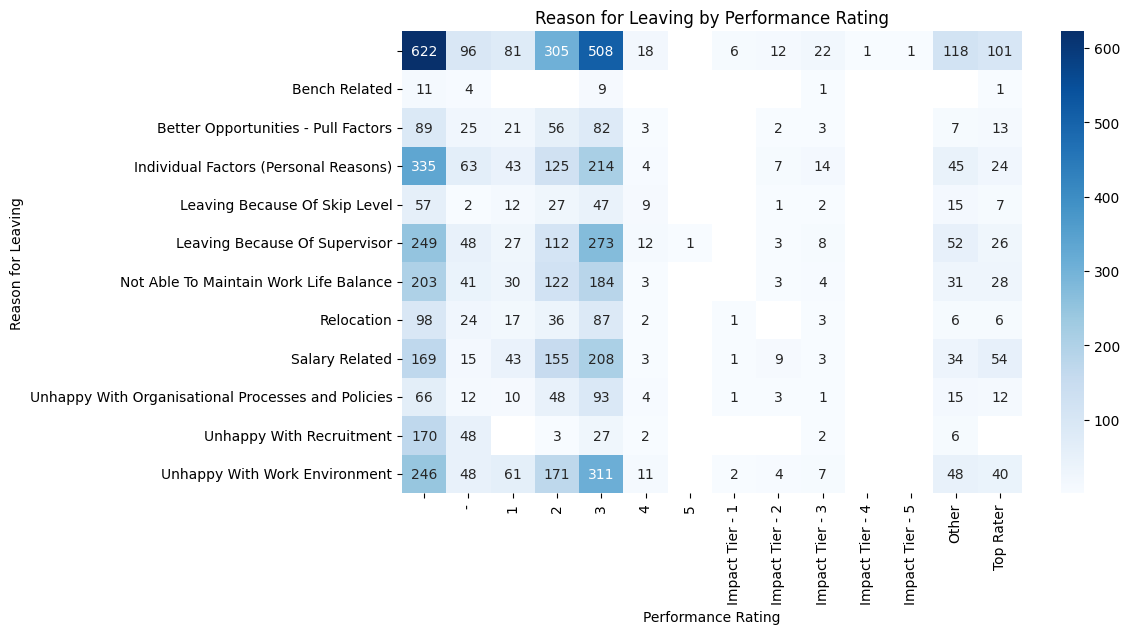

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# solution plan
# i. Group the data by 'Employee_s_Current_performance_rating' and 'Primary_Reason_for_Leaving_Node_1'
# ii. Count the number of occurrences for each combination
# iii. Reset the index of the resulting dataframe
# iv. Pivot the dataframe to have 'Employee_s_Current_performance_rating' as columns and 'Primary_Reason_for_Leaving_Node_1' as rows
# v. Plot the heatmap

def plot(data: pd.DataFrame):
    # Group the data by 'Employee_s_Current_performance_rating' and 'Primary_Reason_for_Leaving_Node_1'
    grouped_data = data.groupby(["Employee's_Current_performance_rating", 'Primary_Reason_for_Leaving_Node_1']).size().reset_index(name='Count')
    
    # Pivot the dataframe
    pivoted_data = grouped_data.pivot(index='Primary_Reason_for_Leaving_Node_1', columns="Employee's_Current_performance_rating", values='Count')
    
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivoted_data, cmap='Blues', annot=True, fmt='g')
    plt.title('Reason for Leaving by Performance Rating')
    plt.xlabel('Performance Rating')
    plt.ylabel('Reason for Leaving')
    
    return plt

chart = plot(df_final)

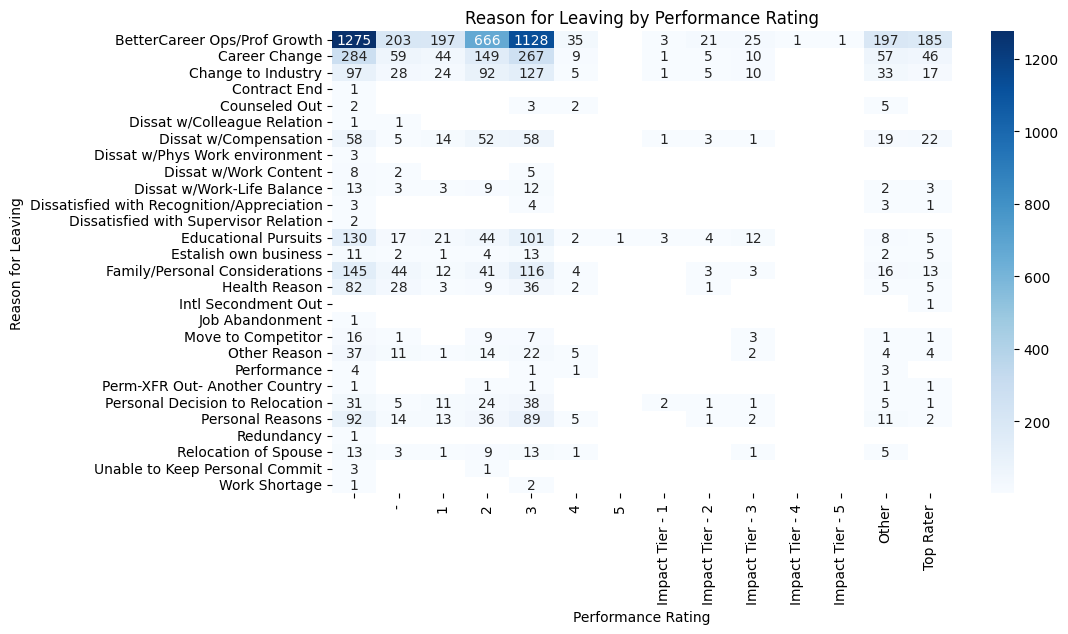

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# solution plan
# i. Group the data by 'Employee_s_Current_performance_rating' and 'Primary_Reason_for_Leaving_Node_1'
# ii. Count the number of occurrences for each combination
# iii. Reset the index of the resulting dataframe
# iv. Pivot the dataframe to have 'Employee_s_Current_performance_rating' as columns and 'Primary_Reason_for_Leaving_Node_1' as rows
# v. Plot the heatmap

def plot(data: pd.DataFrame):
    # Group the data by 'Employee_s_Current_performance_rating' and 'Primary_Reason_for_Leaving_Node_1'
    grouped_data = data.groupby(["Employee's_Current_performance_rating", 'Reason_for_Leaving']).size().reset_index(name='Count')
    
    # Pivot the dataframe
    pivoted_data = grouped_data.pivot(index='Reason_for_Leaving', columns="Employee's_Current_performance_rating", values='Count')
    
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivoted_data, cmap='Blues', annot=True, fmt='g')
    plt.title('Reason for Leaving by Performance Rating')
    plt.xlabel('Performance Rating')
    plt.ylabel('Reason for Leaving')
    
    return plt

chart = plot(df_final)

/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<module 'matplotlib.pyplot' from '/Users/sonali/opt/anaconda3/envs/lida-dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

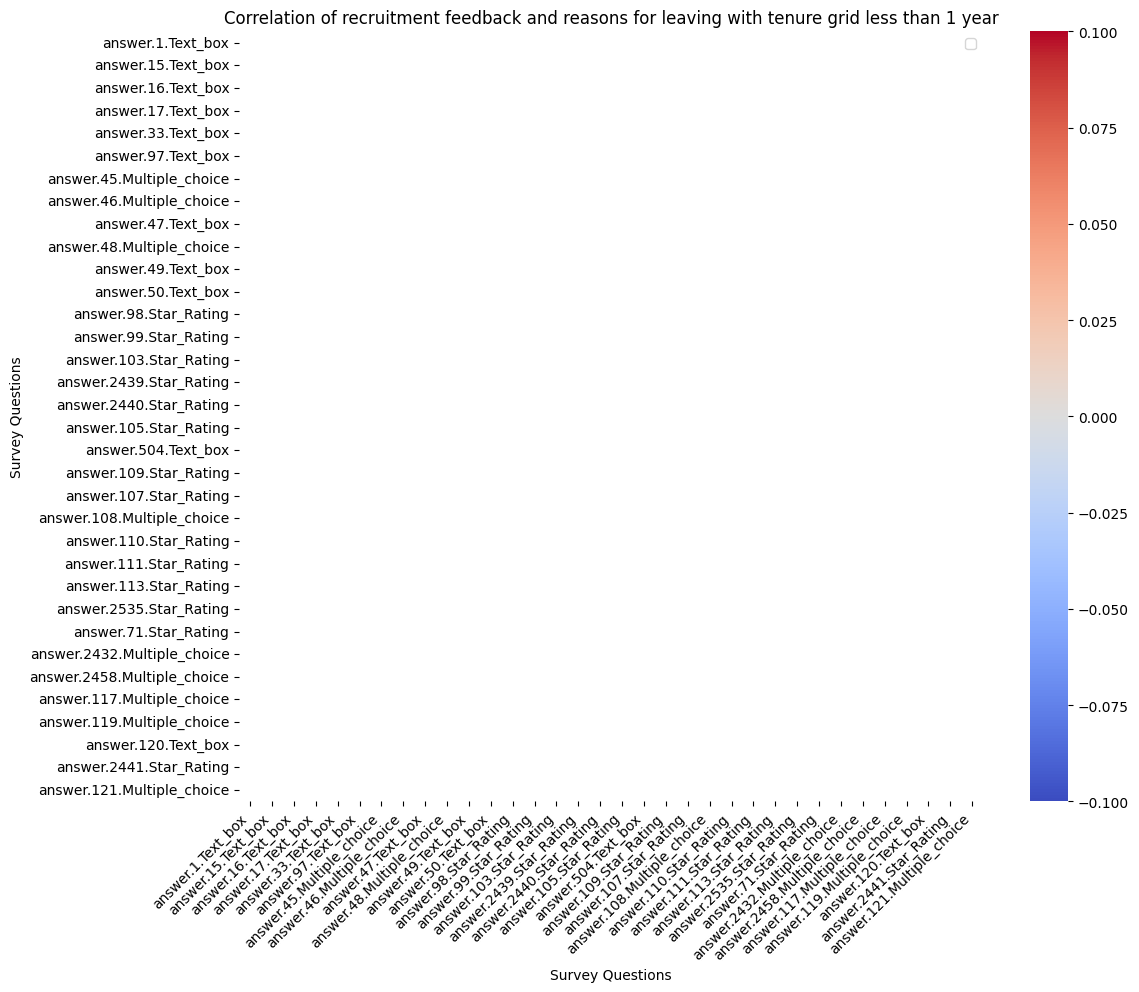

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# solution plan
# i. Filter the dataset to include only rows with tenure grid less than 1 year
filtered_data = df_final[df_final['Tenure_Grid'] == '0 to 12 months']

# ii. Select the relevant columns for correlation analysis
columns = ['answer_1_Text_box', 'answer_15_Text_box', 'answer_16_Text_box', 'answer_17_Text_box', 'answer_33_Text_box', 'answer_97_Text_box', 'answer_45_Multiple_choice', 'answer_46_Multiple_choice', 'answer_47_Text_box', 'answer_48_Multiple_choice', 'answer_49_Text_box', 'answer_50_Text_box', 'answer_98_Star_Rating', 'answer_99_Star_Rating', 'answer_103_Star_Rating', 'answer_2439_Star_Rating', 'answer_2440_Star_Rating', 'answer_105_Star_Rating', 'answer_504_Text_box', 'answer_109_Star_Rating', 'answer_107_Star_Rating', 'answer_108_Multiple_choice', 'answer_110_Star_Rating', 'answer_111_Star_Rating', 'answer_113_Star_Rating', 'answer_2535_Star_Rating', 'answer_71_Star_Rating', 'answer_2432_Multiple_choice', 'answer_2458_Multiple_choice', 'answer_117_Multiple_choice', 'answer_119_Multiple_choice', 'answer_120_Text_box', 'answer_2441_Star_Rating', 'answer_121_Multiple_choice']
new_cols = []
for each in columns:
    parts = each.split('_')
    new_cols.append(f'{parts[0]}.{parts[1]}.{parts[2]}_{parts[3]}')

# iii. Create a correlation matrix
correlation_matrix = filtered_data[new_cols].corr()

# iv. Generate the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# v. Set chart title and labels
plt.title('Correlation of recruitment feedback and reasons for leaving with tenure grid less than 1 year')
plt.xlabel('Survey Questions')
plt.ylabel('Survey Questions')

# vi. Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# vii. Add legend
plt.legend()

# viii. Return the plot
plt
# chart = plot(data)